# BERT Fine-Tuning Tutorial with PyTorch



In this tutorial I'll show you how to use BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification. More broadly, I describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks.




## What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

This post will explain how you can modify and fine-tune BERT to create a powerful NLP model that quickly gives you state of the art results. 



## Advantages of Fine-Tuning



In this tutorial, we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

1. **Quicker Development**

    * First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!). 

2. **Less Data**

    * In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. **Better Results**

    * Finally, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.


# 1. Setup

## 1.1. Using Colab GPU for Training


In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.1 MB/s 
     |████████████████████████████████| 120 kB 63.5 MB/s 
     |████████████████████████████████| 6.6 MB 54.7 MB/s 


# 2. Loading Dataset


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/NLP_Practice/Quora_ques_bert/train.csv'


In [6]:
import pandas as pd
full_data=pd.read_csv(data_path)
full_data.isnull().sum()
full_data.dropna(axis=0,inplace=True)


### Sampling 5000 data points to enhance training speed and optimize memory usage. 

The original dataset consists of 404,348 samples.

In [7]:
# Randomly sample 5000 data points
data = full_data.sample(n=100000)
data_test=full_data.sample(n=20)

print("The percentage of non similar question pairs after sampling is : ")
print(len(data[data['is_duplicate']==0].index)*100/len(data.index))
print("The percentage of similar question pairs after sampling is : ")
print(len(data[data['is_duplicate']==1].index)*100/len(data.index))

# store the labels 
labels = data.is_duplicate.values
labels_test=data_test.is_duplicate.values

The percentage of non similar question pairs after sampling is : 
63.02
The percentage of similar question pairs after sampling is : 
36.98


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 220353 to 127262
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     100000 non-null  object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 5.3+ MB


In [9]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
220353,220353,311749,196055,"In Quora, can we get answers for all questions...",Is there a question that no one on Quora can a...,1
364150,364150,494193,355084,What are the words you don't believe when you ...,"Can I say ""oh my god"" if I don't believe in God?",0
37363,37363,67996,67997,Which is the profitable way to make money onli...,What are the easiest ways to make good money o...,1
354156,354156,483249,112664,How many Bollywood Actresses are showing camel...,How many Bollywood Actresses are comedian in r...,0
290812,290812,68411,412175,What is the best method to learn programming l...,What is the best method to start learning prog...,1


The two properties we actually care about are the the `question1`,`question2` and its `is_duplicate`, which is referred to as the (0=not_duplicate, 1=duplicate).

Here are five sentences which are labeled as not grammatically acceptible. Note how much more difficult this task is than something like sentiment analysis!

In [10]:
data.loc[data.is_duplicate == 0].sample(5)[['question1','question2', 'is_duplicate']]

,question1,question2,is_duplicate
255845,What are some of the loopholes to get more tha...,Can you use a wish from a genie for more wishes?,0
176906,How do I use command prompt?,What are the best ways to learn the command pr...,0
153146,What is the most foolish act you have done tha...,What is the most evil act you've ever done tha...,0
264748,Who would be considered the top 10 pop artists...,Who would be considered the top 10 pop artists...,0
248559,What are some things new employees should know...,What are some things new employees should know...,0




Let's extract the sentences and labels of our training set as numpy ndarrays.

## 3.1. BERT Tokenizer

### Prepare input data for BERT

We need special data preparation methods for BERT. Following are the steps.

1) Tokenize the sentences using the library. 

2) Append the string "[CLS]" to the beginning of the sentence and "[SEP]" to the end of the sentence. 

3) In case of sentence pairs, we need to append "[SEP]" at the end of the second sentence too. 

4) Obtain the input ids of the tokens from the output of the tokenizer. The model needs this to identify tokens uniquely.

5) BERT accepts input sequences in fixed sizes such as 128, 256, 320, 384, 512. So we need to truncate larger sequences or pad smaller sequences with 0.

6) A segment mask is to be specified to identify if the input is a single sentence or pair of sentences. Indicative values such 0 for first sentence and 1 for second sentence are used for this purpose.

7) An attention mask is to be specified, to let the model know which are the tokens and which are the paddings we introduced in step 5. 1 indicates token and 0 indicates padding.

This is the format in which the original BERT model was trained by google. So the users are also expected to follow the same for the best results..



### Special Tokens


## 3.2. Sentences to IDs

In [11]:
# Load pre-trained model tokenizer (vocabulary)
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# function to tokenize and generate input ids for the tokens
# returns a list of input ids

def prep_data(ques1, ques2):
  all_input_ids = []
  
  for (q1,q2) in zip(ques1, ques2):
    
    # first sentence is appended with [CLS] and [SEP] in the beginning and end
    q1 = '[CLS] ' + q1 + ' [SEP] '
    tokens = tokenizer.tokenize(q1)
    
    # 0 denotes first sentence
    seg_ids = [0] * len(tokens)
    
    # second sentence is appended with [SEP] in the end
    q2 = q2 + ' [SEP] '
    tok_q2 = tokenizer.tokenize(q2)
    
    # seg ids is appended with 1 to denote second sentence
    seg_ids += [1] * len(tok_q2)
    
    # first and second sentence tokens are appended together
    tokens += tok_q2
    
    # input ids are generated for the tokens (one question pair)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # input ids are stored in a separate list
    all_input_ids.append(input_ids)
    
  return all_input_ids




In [12]:
all_input_ids = prep_data(data['question1'].values, data['question2'].values) 


In [ ]:
all_input_ids[0]

[101,
 2079,
 2017,
 2228,
 25718,
 2003,
 1996,
 2190,
 4730,
 2653,
 1029,
 2029,
 2653,
 2079,
 2017,
 2228,
 1996,
 2190,
 1029,
 2339,
 1029,
 102,
 2339,
 2003,
 25718,
 1996,
 2190,
 4730,
 2653,
 1999,
 1996,
 2088,
 1029,
 102]

## 3.3. Padding & Truncating

In [13]:
# set MAX_LEN as one of 128, 256, 320, 384, 512
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 128

# Pad our input tokens
pad_input_ids = pad_sequences(all_input_ids,
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

### Attention Mask



The attention mask simply makes it explicit which tokens are actual words versus which are padding. 

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [14]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in pad_input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

Obtain BERT MODEL

## 3.5. Training & Validation Split


In [15]:
# Use train_test_split to split our data into train and validation sets for training

from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(pad_input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, pad_input_ids,
                                             random_state=2018, test_size=0.2)

## 3.6. Converting to PyTorch Data Types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [16]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### Get the same hyperparameters as the model and define the Adam Optimizer

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs=4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

Define a helper function for calculating accuracy.

In [21]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [24]:
import random
import numpy as np


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,500.    Elapsed: 0:00:30.
  Batch    80  of  2,500.    Elapsed: 0:00:58.
  Batch   120  of  2,500.    Elapsed: 0:01:25.
  Batch   160  of  2,500.    Elapsed: 0:01:53.
  Batch   200  of  2,500.    Elapsed: 0:02:21.
  Batch   240  of  2,500.    Elapsed: 0:02:48.
  Batch   280  of  2,500.    Elapsed: 0:03:16.
  Batch   320  of  2,500.    Elapsed: 0:03:44.
  Batch   360  of  2,500.    Elapsed: 0:04:12.
  Batch   400  of  2,500.    Elapsed: 0:04:39.
  Batch   440  of  2,500.    Elapsed: 0:05:07.
  Batch   480  of  2,500.    Elapsed: 0:05:35.
  Batch   520  of  2,500.    Elapsed: 0:06:02.
  Batch   560  of  2,500.    Elapsed: 0:06:30.
  Batch   600  of  2,500.    Elapsed: 0:06:57.
  Batch   640  of  2,500.    Elapsed: 0:07:25.
  Batch   680  of  2,500.    Elapsed: 0:07:53.
  Batch   720  of  2,500.    Elapsed: 0:08:20.
  Batch   760  of  2,500.    Elapsed: 0:08:48.
  Batch   800  of  2,500.    Elapsed: 0:09:15.
  Batch   840  of

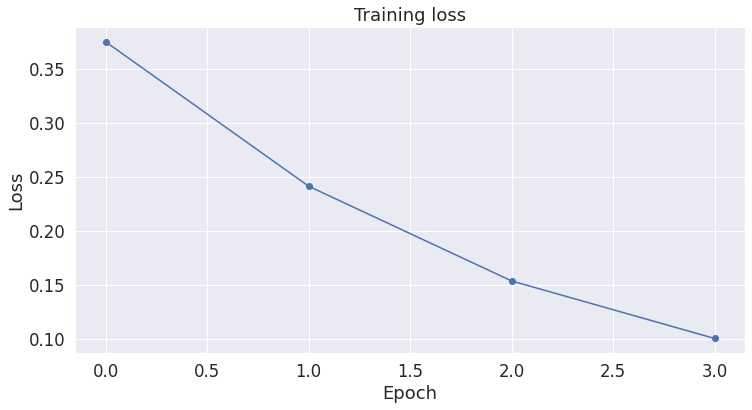

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
#test = pd.read_csv('test1 (2).csv')
all_input_ids_test=[]
question1 = "How can I earn money in YouTube?"
question2 = "How can I earn money using YouTube?"
#all_input_ids = prep_data(test['question1'].values, test['question2'].values)
all_input_ids_test = prep_data_test_foronesample(question1, question2)
print(all_input_ids_test[0])

NameError: ignored

In [ ]:
#all_input_ids_test = prep_data(data_test['question1'].values, data_test['question2'].values) 


In [ ]:
def prep_data_test_foronesample(ques1, ques2):
  all_input_ids_test = []
  all_input_ids=[]
  q1=ques1
  q2=ques2
  
    # first sentence is appended with [CLS] and [SEP] in the beginning and end
  q1 = '[CLS] ' + q1 + ' [SEP] '
  tokens = tokenizer.tokenize(q1)
    
    # 0 denotes first sentence
  seg_ids = [0] * len(tokens)
    
    # second sentence is appended with [SEP] in the end
  q2 = q2 + ' [SEP] '
  tok_q2 = tokenizer.tokenize(q2)
    
    # seg ids is appended with 1 to denote second sentence
  seg_ids += [1] * len(tok_q2)
    
    # first and second sentence tokens are appended together
  tokens += tok_q2
    
    # input ids are generated for the tokens (one question pair)
  input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # input ids are stored in a separate list
  all_input_ids.append(input_ids)
  print(all_input_ids)  
  return all_input_ids


In [ ]:
MAX_LEN = 128
# Pad our input tokens
pad_input_ids_test = pad_sequences(all_input_ids_test,
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

print(pad_input_ids_test)

[[ 101 2129 2064 1045 7796 2769 1999 7858 1029  102 2129 2064 1045 7796
  2769 2478 7858 1029  102    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [ ]:
# Create attention masks
attention_masks_test = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in pad_input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)
print(attention_masks_test)


[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [ ]:
prediction_inputs_test = torch.tensor(pad_input_ids_test)
prediction_masks_test = torch.tensor(attention_masks_test)
  
batch_size = 1


prediction_data = TensorDataset(prediction_inputs_test, prediction_masks_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []
logits=[]

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
 
print(logits)
  #np.array(logits[:2])
  
  
  # Store predictions and true labels
predictions.append(logits)
pred_flat = np.argmax(logits)

print(pred_flat)
  

[[-1.0177978   0.98811376]]
1


# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [26]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/NLP_Practice/Quora_ques_bert/model_save_pytorch_large/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/NLP_Practice/Quora_ques_bert/model_save_pytorch_large/


('/content/drive/MyDrive/NLP_Practice/Quora_ques_bert/model_save_pytorch_large/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_Practice/Quora_ques_bert/model_save_pytorch_large/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_Practice/Quora_ques_bert/model_save_pytorch_large/vocab.txt',
 '/content/drive/MyDrive/NLP_Practice/Quora_ques_bert/model_save_pytorch_large/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K ./model_save_pytorch2/

ls: cannot access './model_save_pytorch2/': No such file or directory


The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./model_save_pytorch2/pytorch_model.bin

ls: cannot access './model_save_pytorch2/pytorch_model.bin': No such file or directory


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

## load model from **disk**

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = '/content/drive/MyDrive/NLP_Practice/Quora_ques_bert/model_save_pytorch2/'

The following functions will load the model back from disk.

In [ ]:
from transformers import BertConfig, BertModel
from transformers import BertTokenizer

from transformers import BertForSequenceClassification

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
#model = model_class.from_pretrained(output_dir)
#tokenizer = tokenizer_class.from_pretrained(output_dir)
model_load = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer_load=BertTokenizer.from_pretrained(output_dir)
config = BertConfig.from_json_file("/content/drive/MyDrive/NLP_Practice/Quora_ques_bert/model_save_pytorch2/config.json")
# Copy the model to the GPU.
#model_load.to(device)



In [ ]:
#test = pd.read_csv('test1 (2).csv')
all_input_ids_test=[]
question1 = "How can I earn money in YouTube?"
question2 = "How can I earn money using YouTube?"
#all_input_ids = prep_data(test['question1'].values, test['question2'].values)
all_input_ids_load = prep_data_load_model(question1, question2)
print(all_input_ids_load[0])

[[101, 2129, 2064, 1045, 7796, 2769, 1999, 7858, 1029, 102, 2129, 2064, 1045, 7796, 2769, 2478, 7858, 1029, 102]]
[101, 2129, 2064, 1045, 7796, 2769, 1999, 7858, 1029, 102, 2129, 2064, 1045, 7796, 2769, 2478, 7858, 1029, 102]


In [ ]:
def prep_data_load_model(ques1, ques2):
  all_input_ids_load = []
  #all_input_ids=[]
  q1=ques1
  q2=ques2
  
    # first sentence is appended with [CLS] and [SEP] in the beginning and end
  q1 = '[CLS] ' + q1 + ' [SEP] '
  tokens = tokenizer_load.tokenize(q1)
    
    # 0 denotes first sentence
  seg_ids = [0] * len(tokens)
    
    # second sentence is appended with [SEP] in the end
  q2 = q2 + ' [SEP] '
  tok_q2 = tokenizer_load.tokenize(q2)
    
    # seg ids is appended with 1 to denote second sentence
  seg_ids += [1] * len(tok_q2)
    
    # first and second sentence tokens are appended together
  tokens += tok_q2
    
    # input ids are generated for the tokens (one question pair)
  input_ids = tokenizer_load.convert_tokens_to_ids(tokens)

    # input ids are stored in a separate list
  all_input_ids_load.append(input_ids)
  print(all_input_ids_load)  
  return all_input_ids_load


In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 128
# Pad our input tokens
pad_input_ids_load = pad_sequences(all_input_ids_load,
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

print(pad_input_ids_load)

[[ 101 2129 2064 1045 7796 2769 1999 7858 1029  102 2129 2064 1045 7796
  2769 2478 7858 1029  102    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [ ]:
# Create attention masks
attention_masks_load = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in pad_input_ids_load:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_load.append(seq_mask)
print(attention_masks_load)


[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [ ]:
# Prediction on test set on load model

# Put model in evaluation mode
#model_load.eval()

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tracking variables 
predictions = []
logits=[]
prediction_inputs_load = torch.tensor(pad_input_ids_load)
prediction_masks_load = torch.tensor(attention_masks_load)

#batch_size = 1


#prediction_data = TensorDataset(prediction_inputs_load, prediction_masks_load)
#prediction_sampler = SequentialSampler(prediction_data)
#prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


print(prediction_inputs_load)
print(prediction_masks_load)
#model_load.eval()
#for batch in prediction_dataloader:
  
  #batch = tuple(t for t in batch)
  # Unpack the inputs from our dataloader
  #b_input_ids, b_input_mask = batch  
           
outputs = model_load(prediction_inputs_load, attention_mask=prediction_masks_load)
                
logits = outputs[0]

logits = logits.detach().cpu().numpy()
 
print(logits)
  #np.array(logits[:2])
  
  
  # Store predictions and true labels
predictions.append(logits)
pred_flat = np.argmax(logits, axis=1)

print(pred_flat)
  

tensor([[ 101, 2129, 2064, 1045, 7796, 2769, 1999, 7858, 1029,  102, 2129, 2064,
         1045, 7796, 2769, 2478, 7858, 1029,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

## A.2. Weight Decay



The huggingface example includes the following code block for enabling weight decay, but the default decay rate is "0.0", so I moved this to the appendix.

This block essentially tells the optimizer to not apply weight decay to the bias terms (e.g., $ b $ in the equation $ y = Wx + b $ ). Weight decay is a form of regularization--after calculating the gradients, we multiply them by, e.g., 0.99.

In [ ]:
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.